**Bayes' Theorem**
$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$
*parametric:*
$$
MAP: a(x) = \arg \max_{y_i}{ P(X|y_i = C_k) P(y_i = C_k)}= \\ = \arg \max_{y_i}\ \ln P(X|y_i = C_k) + \ln P(y_i = C_k) =\arg \max_{y_i}\ \ln \prod_j^dP(X_j|y_i = C_k) + \ln P(y_i = C_k) = \\ =\arg \max_{y_i}\ \sum_j^d \ln P(X_j|y_i = C_k) + \ln P(y_i = C_k) \to MLE \ for \ distributions
$$

In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp


class NaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, X, y, sample_weight=None, distributions=None):
        self.unique_labels = np.unique(y)

        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]
        else:
            assert len(distributions) == X.shape[1]

        # P(x^i|y=C_k)
        self.conditional_feature_distributions = {} # label: [distibution(feature_i) for feature_1, ...]
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                feature_column = X[y == label, column_index] #y_label!
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distributions[label] = feature_distribution

        # p(y=C_k)
        self.prior_label_distibution = {
            label: sum((y==label).astype(float)) / len(y)
            for label in self.unique_labels
        }

    def predict_log_proba(self, X):
        # matrix of shape (n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)

        # compute the class log probabilities for each class sequentially b
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # + all loglikelihood for every feature w.r.t. fixed label
                class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx])

            # + log proba of label prior
            class_log_probas[:, label_idx] += np.log(self.prior_label_distibution[label])

        for idx in range(X.shape[1]):
        # get probabilities, you need to substract the log proba for every feature
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None]
        return class_log_probas

    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # cast labels to their original form (they may start from number other than 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])

## iris dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

In [2]:
matplotlib.rcParams['font.size'] = 11

In [3]:
dataset = datasets.load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [4]:

ext_target = dataset.target[:, None]
pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


In [5]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

## visualize dataset

Our dataset has 4 dimensions however humans are more common to 3 or even 2 dimensional data, so let's plot first 3 features colored with labels values

In [6]:
from mpl_toolkits.mplot3d import Axes3D

In [7]:
fig = plt.figure(figsize=(8, 8))

ax = Axes3D(fig)

ax.scatter(features[:, 0], features[:, 1], features[:, 3], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])

plt.show()

<Figure size 800x800 with 0 Axes>

Then have a look on feature distributions

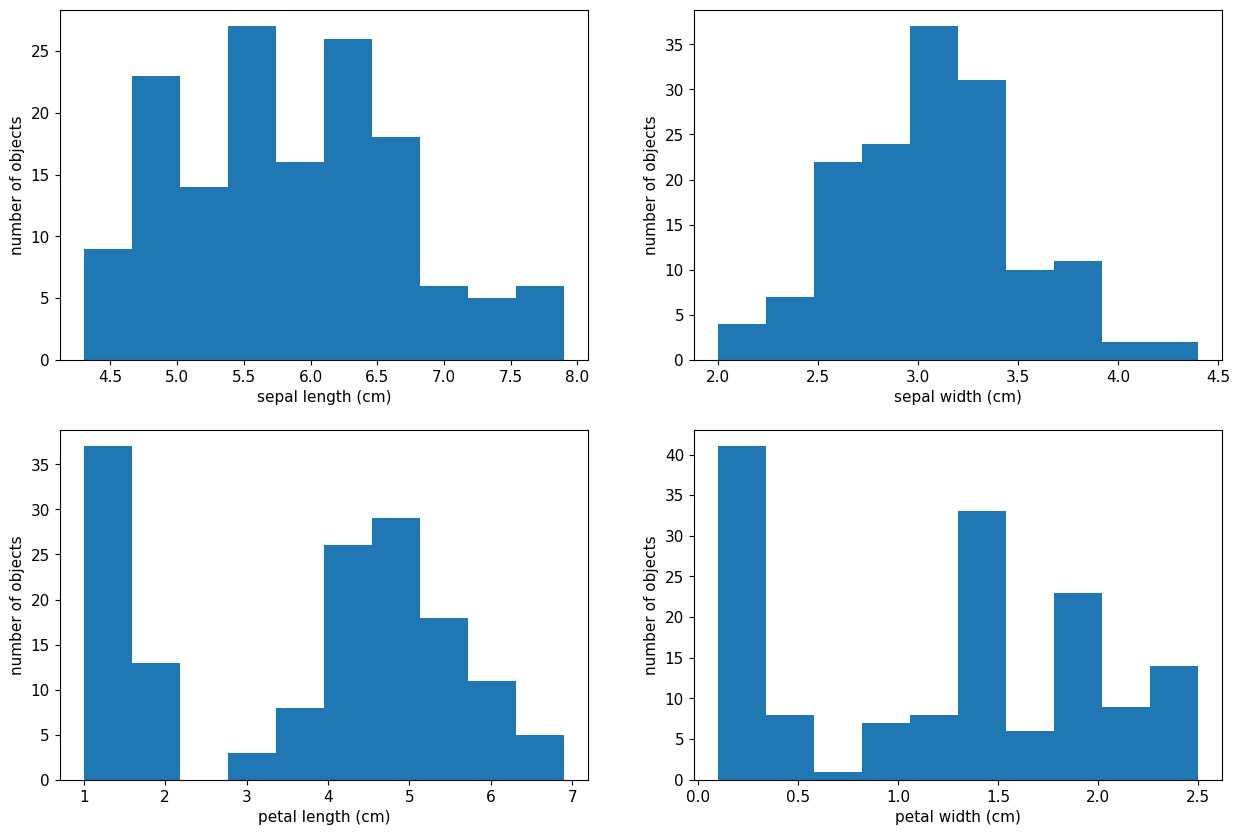

In [8]:
# remember this way to make subplots! It could be useful for you later in your work

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, axis in enumerate(axes.flat):
    axis.hist(features[:, i])
    axis.set_xlabel(dataset.feature_names[i])
    axis.set_ylabel('number of objects')

##distributions

**Normal:**
$$ \mathcal{N}(x|\mu, \sigma^2)=
p(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})
$$


$$ \ln(\mathcal{N}(x|\mu, \sigma^2))=
\ln(p(x|\mu, \sigma^2)) = \ln(\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2})) = \\ = - \frac{(x - \mu)^2}{2\sigma^2} - \frac{1}{2} \ln(2 \pi \sigma^2)
$$

$MLE:$ $$\mu = \mathbb{E}_{\xi}=\overline{X} $$ \\
$$\sigma = \overline{\sigma} = \sqrt{\frac{1}{|X|}(\sum_iX_i-\overline{X})}$$

$unbiased:$
$$\sigma = \overline{\sigma} = \sqrt{\frac{1}{|X|-1}(\sum_iX_i-\overline{X})}$$

In [9]:
class GaussianDistribution:
    def __init__(self, feature):
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)

    def logpdf(self, value):
        return - 0.5 * np.log(2. * np.pi * self.std**2) - (value - self.mean)**2 / (2 * self.std**2)

    def pdf(self, value):
        return np.exp(self.logpdf(value))

**Laplace:**

$$\mathcal{L}(\mu, b) = p(x|\mu, b) = \frac{1}{2b}\exp(-\frac{|x - \mu|}{b})
$$
$MLE:$
$$
\hat{\mu} = \mathrm{median}(x).
$$

$$
\hat{b} = \frac{1}{n} \sum_{i = 1}^{n} |x_i - \hat{\mu}|.$$
$unbiased:$
$$\hat{b}^* = \hat{b} \cdot n/(n-2)$$


In [11]:
import numpy as np
class LaplaceDistribution:
  def __init__(self, feature: np.ndarray):
    self.len_ = feature.shape[0]
    self.loc = np.quantile(feature, 0.5, axis=0)
    self.scale = (np.sum(np.abs(feature - self.loc), axis=0)) / self.len_
#   self.correct_mad_from_median = self.mad_from_median * self.len_ / (self.len_ - 2)

  def logpdf(self, value):
        return -np.log(2) - np.log(self.scale) - np.abs(value - self.loc) / (self.scale)

  def pdf(self, value):
      return np.exp(self.logpdf(value))

## distribution parameters check

In [ ]:
import scipy
_test = scipy.stats.norm(loc=features[:, :2].mean(axis=0), scale=features[:, :2].std(axis=0))
assert np.allclose(
    GaussianDistribution(features[:, :2]).logpdf(features[:5, :2]),
    _test.logpdf(features[:5, :2])
)
print('Seems fine!')

In [12]:
my_distr_1 = LaplaceDistribution(features[:, 0])
my_distr_1.scale
# scale0

0.6846666666666668

In [13]:
loc0, scale0 = scipy.stats.laplace.fit(features[:, 0])
loc1, scale1 = scipy.stats.laplace.fit(features[:, 1])

In [14]:
# 1d case
my_distr_1 = LaplaceDistribution(features[:, 0])

# check the 1d median (loc parameter)
assert np.allclose(my_distr_1.loc, loc0), '1d distribution median error'
# check the 1d scale (scale parameter)
assert np.allclose(my_distr_1.scale, scale0), '1d distribution scale error'

print('Seems fine!')

Seems fine!


In [15]:
# 2d case
my_distr_2 = LaplaceDistribution(features[:, :2])

# check the 2d median (loc parameter)
assert np.allclose(my_distr_2.loc, np.array([loc0, loc1])), '2d distribution median error'
# check the 2d scale (scale  parameter)
assert np.allclose(my_distr_2.scale, np.array([scale0, scale1])), '2d distribution scale error'

print('Seems fine!')

Seems fine!


In [16]:
_test = scipy.stats.laplace(loc=[loc0, loc1], scale=[scale0, scale1])

assert np.allclose(
    my_distr_2.logpdf(features[:5, :2]),
    _test.logpdf(features[:5, :2])
), 'Logpdfs do not match scipy results!'
print('Seems fine!')

Seems fine!


In [17]:
my_distr_2.pdf(features[:5, :2])
_test.pdf(features[:5, :2])

array([[0.26270611, 0.3333376 ],
       [0.1961585 , 1.51209677],
       [0.14646845, 0.82585057],
       [0.12656469, 1.11748198],
       [0.22700669, 0.24634585]])

## classifier implementation

In [19]:
features.shape[1]

4

In [20]:
nb = NaiveBayes()
nb.fit(features, target)
print('log probas:\n{}'.format(nb.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb.predict(features[:2])))
print('\nIt`s alive! More tests coming.')

log probas:
[[  0.         -41.14063634 -57.90531295]
 [  0.         -38.72865982 -56.71097942]]
predicted labels:
[0 0]

It`s alive! More tests coming.


In [21]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)

print(features_train.shape, features_test.shape)

(112, 4) (38, 4)


In [22]:
nb = NaiveBayes()
nb.fit(features_train, target_train, distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)

In [23]:
print('Naive Bayes classifier accuracy on the train set: {}'.format(nb.score(features_train, target_train)))

Naive Bayes classifier accuracy on the train set: 0.9553571428571429


In [24]:
print('Naive Bayes classifier accuracy on the test set: {}'.format(nb.score(features_test, target_test)))

Naive Bayes classifier accuracy on the test set: 0.9736842105263158


In [25]:
from sklearn import naive_bayes

sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(features_train, target_train)
sklearn_nb_test_log_proba = sklearn_nb.predict_log_proba(features_test)

In [26]:
print('sklearn implementation accuracy on the train set: {}'.format(sklearn_nb.score(features_train, target_train)))

sklearn implementation accuracy on the train set: 0.9553571428571429


In [27]:
print('sklearn implementation accuracy on the test set: {}'.format(sklearn_nb.score(features_test, target_test)))

sklearn implementation accuracy on the test set: 0.9736842105263158


In [28]:
assert np.allclose(nb_test_log_proba, sklearn_nb_test_log_proba), 'log probabilities do not match'
print('Seems alright!')

Seems alright!


## comparing to kNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
knn = KNeighborsClassifier(n_neighbors=2)

In [31]:
knn.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=2)

In [32]:
knn.score(features_train, target_train)

0.9821428571428571

In [33]:
knn.score(features_test, target_test)

0.9473684210526315